In [1]:
import numpy as np
import matplotlib.pyplot as roberplot
import ipywidgets as widgets
import pickle
from ipywidgets import interact
from scipy.stats import expon
from IPython.display import display, update_display, clear_output
%matplotlib inline

## Discrete Model

In [804]:
class World():
    def __init__(self, params):
        # World params
        self.hr = params["hare_reproduction_rate"]
        self.lr = params["lynx_reproduction_rate"]
        self.hs = params["successful_hunt_probability"]
        self.ld = params["lynx_death_rate"]
        self.w_size = params["world_size"]
        self.hrg = params["lynx_hunting_range"]
        self.mrg = params["moving_range"]
        
        # Data structures and population initialization
        self.hares = []
        self.lynxes = []
        self.hunts = []
        self.hare_deltas = [0]
        self.lynx_deltas = [0]
        self.migrations = []
        self.hares.append(np.zeros((self.w_size, self.w_size), dtype="int32"))
        self.lynxes.append(np.zeros((self.w_size, self.w_size), dtype="int32"))
        self.hunts.append(np.zeros((self.w_size, self.w_size), dtype="int32"))
        rand_pos = np.random.randint(0, self.w_size, size=(params["initial_hares"], 2))
        rand_pos_unique, rand_count = np.unique(rand_pos, axis=0, return_counts = True)
        rand_count -= 1
        self.hares[0][rand_pos_unique[:,0], rand_pos_unique[:,1]] += rand_count.astype("int32")
        self.hares[0][rand_pos[:,0],rand_pos[:,1]] += 1
        rand_pos = np.random.randint(0, self.w_size, size=(params["initial_lynxes"], 2))
        rand_pos_unique, rand_count = np.unique(rand_pos, axis=0, return_counts = True)
        rand_count -= 1
        self.lynxes[0][rand_pos_unique[:,0], rand_pos_unique[:,1]] += rand_count.astype("int32")
        self.lynxes[0][rand_pos[:,0],rand_pos[:,1]] += 1
    
    def timestep(self):
        # Create new timestep data structures
        self.hares.append(self.hares[-1].copy())
        self.lynxes.append(self.lynxes[-1].copy())
        self.hunts.append(np.zeros((self.w_size, self.w_size), dtype="int32"))    
        # Perform the simulation
        self.hunt()
        self.die()
        self.move()
        self.reproduce()
        # Avoid zero population case
        hsum = np.sum(self.hares[-1], axis=(0,1), dtype="int32")
        lsum = np.sum(self.lynxes[-1], axis=(0,1), dtype="int32")
        self.lynx_deltas.append(lsum - np.sum(self.lynxes[-2], axis=(0,1), dtype="int32"))
        self.hare_deltas.append(hsum - np.sum(self.hares[-2], axis=(0,1), dtype="int32"))    
        clear_output(wait=True)
        display(['Hares: ', hsum])
        display(['Lynxes: ', lsum])
        
    def hunt(self):
        # Select lynxes in the map
        nz = np.nonzero(self.lynxes[-1])
        lynx_count = self.lynxes[-1][nz]
        nz = list(zip(nz[0], nz[1]))
        # Set window size according to hunting range and compute index slice.
        window_size = 2*self.hrg+1
        row, col = np.indices((window_size,window_size))
        row -= self.hrg
        col -= self.hrg
        
        for i in range(len(nz)):
            x,y = nz[i]
            for _ in range(lynx_count[i]):
                # Select window according to hunting range.
                window = self.hares[-1][(x+row)%self.w_size , (y+col)%self.w_size]
                if window.sum() == 0:
                    continue
                for j in range(window_size):
                    for k in range(window_size):
                        if window[j,k] == 0:
                            continue
                        success = (np.random.rand(window[j,k]) <= self.hs).sum()
                        if success != 0:
                            self.hunts[-1][nz[i]] += 1
                        window[j,k] -= np.min((success, 1))
                self.hares[-1][(x+row)%self.w_size , (y+col)%self.w_size] = window
        

    def die(self):
        # Lynxes
        nz = np.nonzero(self.lynxes[-1])
        lynx_count = self.lynxes[-1][nz]
        nz = list(zip(nz[0], nz[1]))
        for i in range(len(nz)):
            success = (np.random.rand(lynx_count[i]) <= self.ld).sum()
            self.lynxes[-1][nz[i]] -= success
       
    def move(self):
        migrations = 0
        # Hares
        nz = np.nonzero(self.hares[-1])
        hare_count = self.hares[-1][nz]
        nz = list(zip(nz[0], nz[1]))
        window_size = 2*self.mrg + 1
        moves = np.random.randint(0, window_size**2, size=hare_count.sum())
        self.hares[-1][:] = 0
        move_count = 0
        for i in range(len(nz)):
            x, y = nz[i]
            if (x == 0 or x == self.w_size-1) or (y == 0 or y == self.w_size-1):
                migrations += hare_count[i]
            for k in range(hare_count[i]):
                x_offset = moves[move_count]//window_size - self.mrg
                y_offset = moves[move_count]%window_size - self.mrg
                self.hares[-1][(x + x_offset)%self.w_size, (y + y_offset)%self.w_size] += 1
                move_count += 1
        # Lynxes
        nz = np.nonzero(self.lynxes[-1])
        lynx_count = self.lynxes[-1][nz]
        nz = list(zip(nz[0], nz[1]))
        window_size = 2*self.mrg + 1
        moves = np.random.randint(0, window_size**2, size=lynx_count.sum())
        self.lynxes[-1][:] = 0
        move_count = 0
        for i in range(len(nz)):
            x, y = nz[i]
            if (x == 0 or x == self.w_size-1) or (y == 0 or y == self.w_size-1):
                migrations += lynx_count[i]
            for k in range(lynx_count[i]):
                x_offset = moves[move_count]//window_size - self.mrg
                y_offset = moves[move_count]%window_size - self.mrg
                self.lynxes[-1][(x + x_offset)%self.w_size, (y + y_offset)%self.w_size] += 1
                move_count += 1
        self.migrations.append(migrations)
    
    def reproduce(self):
        # Hares
        nz = np.nonzero(self.hares[-1])
        hare_count = self.hares[-1][nz]
        nz = list(zip(nz[0], nz[1]))
        for i in range(len(nz)):
            success = (np.random.rand(hare_count[i]) <= self.hr).sum()
            self.hares[-1][nz[i]] += success
        # Lynxes
        nz = np.nonzero(self.hunts[-1])
        lynx_count = self.hunts[-1][nz]
        nz = list(zip(nz[0], nz[1]))
        for i in range(len(nz)):
            success = (np.random.rand(lynx_count[i]) <= self.lr).sum()
            self.lynxes[-1][nz[i]] += success

        
    def plot_heatmaps(self, timestep):
        fig, axes = roberplot.subplots(1,3)
        fig.set_size_inches(16,4)
        axes[0].imshow(self.hares[timestep], cmap="Reds")
        axes[0].set_title("Hares spatial distribution")
        axes[0].set_xlabel("Total units = " + str(self.hares[timestep].sum()))
        axes[1].imshow(self.lynxes[timestep], cmap="Blues")
        axes[1].set_title("Lynxs spatial distribution")
        axes[1].set_xlabel("Total units = " + str(self.lynxes[timestep].sum()))
        axes[2].imshow(self.hunts[timestep], cmap="Greens")
        axes[2].set_title("Successful Hunts")
        axes[2].set_xlabel("Total hunts = " + str(self.hunts[timestep].sum()))
        
    def plot_stats(self):
        fig, axes = roberplot.subplots(2,2)
        fig.set_size_inches(16,8)
        axes[0][0].plot(np.sum(self.hares, axis=(1,2)), label="Hare population")
        axes[0][0].plot(np.sum(self.lynxes, axis=(1,2)), label="Lynx population")
        axes[0][0].set_xlabel("Timesteps")
        axes[0][0].set_ylabel("Population")
        axes[0][0].legend()
        axes[0][0].set_title("Populations over time")
        hsum = np.sum(self.hares, axis=(1,2))
        lsum = np.sum(self.lynxes, axis=(1,2))
        axes[0][1].plot(hsum/hsum.max(), lsum/lsum.max())
        axes[0][1].set_xlabel("Hare population")
        axes[0][1].set_ylabel("Lynx population")
        axes[0][1].legend()
        axes[0][1].axis("equal")
        axes[0][1].set_title("Phase")
        #axes[1][0].plot(self.avg_interaction, label="Interaction")
        axes[1][0].plot(self.hare_deltas)
        axes[1][0].plot(self.lynx_deltas)
        axes[1][0].set_xlabel("Timesteps")
        axes[1][0].set_ylabel("Deltas")
        axes[1][0].legend()
        axes[1][0].set_title("Population Deltas")
        axes[1][1].plot(self.migrations)
        #axes[1][1].plot((hsum+lsum)*0.2)
        axes[1][1].set_ylabel("Potential Migrations")
        axes[1][1].set_xlabel("Timesteps")
        axes[1][1].legend()
        axes[1][1].set_title("Migrations")
        fig.tight_layout()

In [805]:
# Whenever timesteps change, params must be modified accordingly.
timesteps = 1000

params = {
    "initial_hares": 155,
    "initial_lynxes": 80,
    "hare_reproduction_rate": 0.08,
    "lynx_reproduction_rate": 0.90,
    "lynx_death_rate": 0.08,
    "successful_hunt_probability": 0.5,
    "lynx_hunting_range": 2,
    "moving_range": 1,
    "world_size": 100
}

np.random.seed(123)

world = World(params)
for t in range(timesteps):
    world.timestep()

['Hares: ', 1871]

['Lynxes: ', 987]

A Jupyter Widget

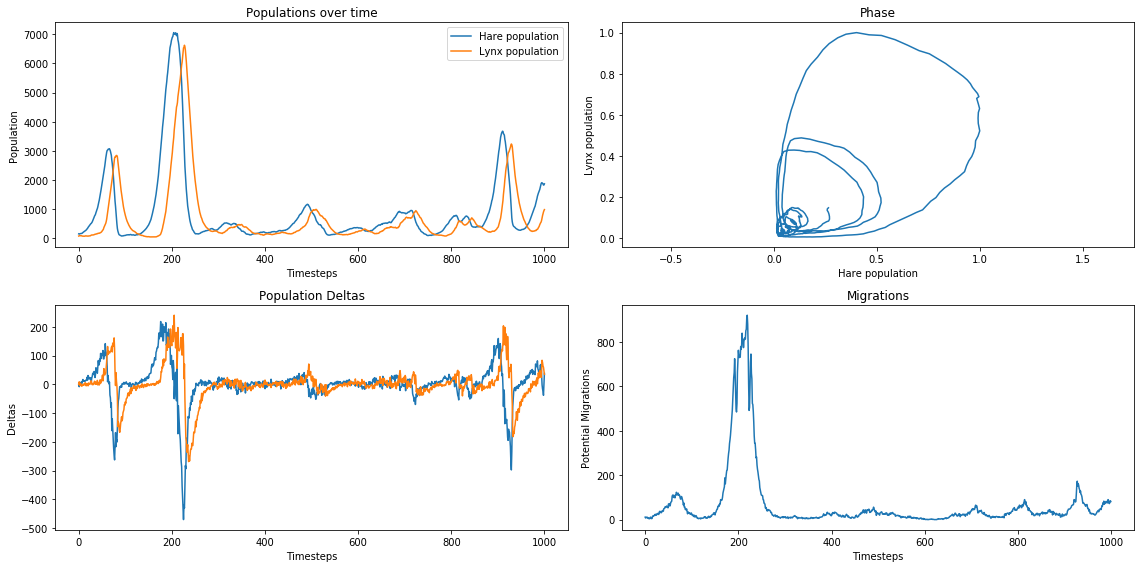

In [806]:
interact(world.plot_heatmaps, timestep=widgets.IntSlider(value=0, min=0, max=timesteps))
world.plot_stats()

In [721]:
from scipy import interpolate

hsums = np.sum(world.hares, axis=(1,2), dtype="int32")
lsums = np.sum(world.lynxes, axis=(1,2), dtype="int32")

f = (world.lynx_deltas/lsums + world.ld)/(world.hs*world.lr)
g = (world.hr - world.hare_deltas/hsums)/(world.hs)

data = np.vstack((data, np.array([hsums, lsums, f, g]).T))

0.011127625573698485

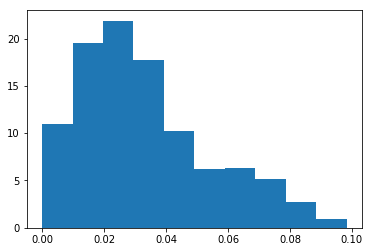

In [803]:
roberplot.hist(world.migrations/(lsums[1:]+ hsums[1:]), density=True)
(world.migrations/(lsums[1:]+ hsums[1:])).mean()/3

(array([  0.45998618,   2.29993089,   5.97982031,   9.26543586,
         13.17531837,  18.26802248,  19.18799484,  21.09365186,
         22.47361039,  23.03216503,  22.34218577,  20.1736795 ,
         19.68083717,  17.31519397,  15.24525617,  15.08097539,
         13.04389375,  10.57968208,   9.39686048,   8.80544969,
          6.5055188 ,   6.2098134 ,   5.12556026,   4.33701253,
          3.44989633,   2.957054  ,   2.46421167,   1.83994471,
          1.80708855,   1.08425313,   1.41281469,   0.98568467,
          0.65712311,   0.75569158,   0.42713002,   0.36141771,
          0.2957054 ,   0.2957054 ,   0.09856847,   0.09856847,
          0.06571231,   0.16428078,   0.06571231,   0.03285616,
          0.03285616,   0.06571231,   0.        ,   0.        ,
          0.        ,   0.06571231]),
 array([ 0.00169661,  0.00474018,  0.00778375,  0.01082732,  0.01387088,
         0.01691445,  0.01995802,  0.02300159,  0.02604516,  0.02908873,
         0.0321323 ,  0.03517587,  0.03821944,  

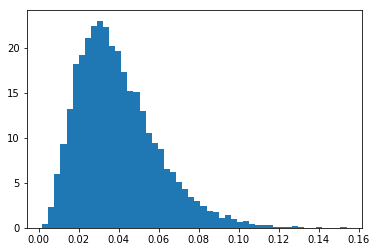

In [815]:
from scipy.stats import lognorm, expon, gamma
r = gamma(a=3.99, loc=0, scale=1/100)
roberplot.hist(r.rvs(size=10000), density=True, bins=50)

## Continuous Model

In [816]:
from scipy import interpolate
from scipy.stats import norm, expon, gamma

class Zone():
    def __init__(self, params):
        # World params
        self.hr = params["hare_reproduction_rate"]
        self.lr = params["lynx_reproduction_rate"]
        self.hs = params["successful_hunt_probability"]
        self.ld = params["lynx_death_rate"]
    
        self.hares = [params["initial_hares"]]
        self.lynxes = [params["initial_lynxes"]]
        self.data = pickle.load(open("interpolation_data", "rb"))
        self.f_inter = interpolate.bisplrep(data[1:,0], data[1:,1], data[:-1,2], s=100)
        self.f = lambda h, l: interpolate.bisplev(h, l, self.f_inter)
        self.g_inter = interpolate.bisplrep(data[1:,0], data[1:,1], data[:-1,3], s=100)
        self.g = lambda h, l: interpolate.bisplev(h, l, self.g_inter)
        
        #self.f1_inter = interpolate.NearestNDInterpolator(np.column_stack((self.data[1:,0], self.data[1:,1])), self.data[:-1,2])
        #self.g1_inter = interpolate.NearestNDInterpolator(np.column_stack(([self.data[1:,0], self.data[1:,1]])), self.data[:-1,3])
        #self.f1 = lambda h,l: self.f1_inter((h,l))
        #self.g1 = lambda h,l: self.g1_inter((h,l))
        
        #self.f2_inter = norm(loc=f.mean(), scale=f.std())
        #self.f2 = lambda x,y: self.f2_inter.rvs()
        #self.g2_inter = norm(loc=g.mean(), scale=g.std())
        #self.g2 = lambda x,y: self.g2_inter.rvs()

    def timestep(self):
        #print(self.g(self.hares[-1], self.lynxes[-1]), self.f(self.hares[-1], self.lynxes[-1]))
        next_hares = (1 + self.hr - self.hs*self.g(self.hares[-1], self.lynxes[-1]))*self.hares[-1]
        next_lynxes = (1 - self.ld + self.f(self.hares[-1], self.lynxes[-1])*self.lr*self.hs)*self.lynxes[-1]
        self.hares.append(np.clip(next_hares, a_min=0, a_max=15000))
        self.lynxes.append(np.clip(next_lynxes, a_min=0, a_max=15000))
    
    def plot(self):
        fig, axes = roberplot.subplots(1,2)
        fig.set_size_inches(16,4)
        axes[0].plot(self.hares, label="Hare population")
        axes[0].plot(self.lynxes, label="Lynx population")
        axes[0].legend()
        axes[1].plot(self.hares, self.lynxes)
        axes[1].set_xlabel("Hare Population")
        axes[1].set_ylabel("Lynx Population")
        fig.tight_layout()

In [825]:
# Whenever timesteps change, params must be modified accordingly.
params = {
    "initial_hares": 155,
    "initial_lynxes": 80,
    "hare_reproduction_rate": 0.09,
    "lynx_reproduction_rate": 0.9,
    "lynx_death_rate": 0.06,
    "successful_hunt_probability": 0.5
}

#np.random.seed(123)

zone = Zone(params)

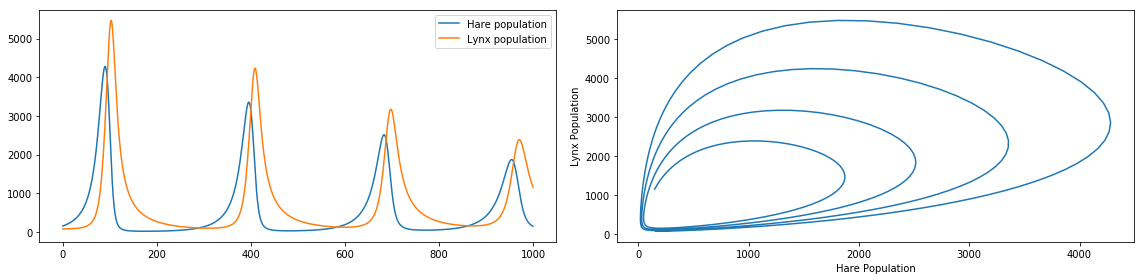

In [826]:
timesteps = 1000
for i in range(timesteps):
    zone.timestep()
zone.plot()

### Zone Grid

In [830]:
from scipy.stats import gamma

class Grid():
    def __init__(self, params):
        self.grid_size = params["grid_size"]
        self.init_range = params["init_range"]
        self.hr = params["hare_reproduction_rate"]
        self.lr = params["lynx_reproduction_rate"]
        self.hs = params["successful_hunt_probability"]
        self.ld = params["lynx_death_rate"]
        
        self.hares = [(self.init_range[1] - self.init_range[0])*np.random.rand(self.grid_size, self.grid_size) + self.init_range[0]]
        self.lynxes = [(self.init_range[1] - self.init_range[0])*np.random.rand(self.grid_size, self.grid_size) + self.init_range[0]]
        
        self.m = gamma(a=3.99, loc=0, scale=0.01)
        
        self.data = pickle.load(open("interpolation_data", "rb"))
        self.f_inter = interpolate.bisplrep(data[1:,0], data[1:,1], data[:-1,2], s=100)
        self.f = lambda h, l: interpolate.bisplev(h, l, self.f_inter)
        self.f = np.vectorize(self.f)
        self.g_inter = interpolate.bisplrep(data[1:,0], data[1:,1], data[:-1,3], s=100)
        self.g = lambda h, l: interpolate.bisplev(h, l, self.g_inter)
        self.g = np.vectorize(self.g)
    
    def timestep(self):
        next_hares = (1 + self.hr - self.hs*self.g(self.hares[-1], self.lynxes[-1]))*self.hares[-1]
        next_lynxes = (1 - self.ld + self.f(self.hares[-1], self.lynxes[-1])*self.lr*self.hs)*self.lynxes[-1]
        
        m_coef = self.m.rvs(size=(self.grid_size, self.grid_size))
        hm = next_hares*m_coef
        flux = np.roll(hm, 1, axis=0) + np.roll(hm, -1, axis=0) + np.roll(hm, 1, axis=1) + np.roll(hm, -1, axis=1)
        flux = -hm + flux/4
        next_hares += flux
        
        m_coef = self.m.rvs(size=(self.grid_size, self.grid_size))
        lm = next_lynxes*m_coef
        flux = np.roll(lm, 1, axis=0) + np.roll(lm, -1, axis=0) + np.roll(lm, 1, axis=1) + np.roll(lm, -1, axis=1)
        flux = -lm + flux/4
        next_lynxes += flux
        
        self.hares.append(np.clip(next_hares, a_min=0, a_max=15000))
        self.lynxes.append(np.clip(next_lynxes, a_min=0, a_max=15000))
        
    def plot_heatmaps(self, timestep):
        fig, axes = roberplot.subplots(1,2)
        fig.set_size_inches(16,4)
        axes[0].imshow(self.hares[timestep], cmap="Reds")
        axes[0].set_title("Hares per Zone")
        axes[0].set_xlabel("Total units = " + str(self.hares[timestep].sum()))
        axes[1].imshow(self.lynxes[timestep], cmap="Blues")
        axes[1].set_title("Lynxs per Zone")
        axes[1].set_xlabel("Total units = " + str(self.lynxes[timestep].sum()))

In [833]:
params = {
    "grid_size": 100,
    "init_range": (10,50),
    "hare_reproduction_rate": 0.09,
    "lynx_reproduction_rate": 0.9,
    "lynx_death_rate": 0.06,
    "successful_hunt_probability": 0.5
}

grid = Grid(params)

In [834]:
timesteps = 1000
for _ in range(timesteps):
    grid.timestep()

interact(grid.plot_heatmaps, timestep=widgets.IntSlider(value=0, min=0, max=timesteps))

A Jupyter Widget

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>>

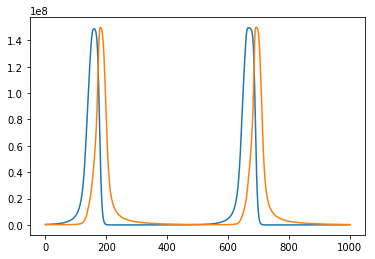

In [836]:
roberplot.plot(np.sum(grid.hares, axis=(1,2)))
roberplot.plot(np.sum(grid.lynxes, axis=(1,2)))